# Découverte du package MLLIB 

## Analyse explo (rapide) 

In [1]:
import utils
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import DataFrame

In [2]:
# chargement du fichier glass.csv
nomF = "glass"
dataGlass = sc.textFile("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF+".csv")
# séparation des colonnes
lines = dataGlass.map(lambda line: utils.toRow(line, ';'))
# ligne 1 = header -> save header
nomColInit = lines.take(1)[0]
# save nb col
nbColInit = len(nomColInit)
# sruppression du header
parts = lines.filter(lambda line: nomColInit != line) 
parts = parts.filter(lambda line: len(line) == nbColInit)
# cptage nb lignes (sans le header)   
nbLignesInit = parts.count()
# cptage erreur : nb col header != nb col de la ligne 
partsError = parts.filter(lambda line: len(line) != nbColInit)
nbErrorL = partsError.count()
# tableau résumé 
data = pd.DataFrame({'1-nom Fichier':[nomF],
                       '2-nb Col':[nbColInit],
                       '3-nb Lignes': [nbLignesInit],
                        '4-nb Lignes error': [nbErrorL]})
data

,1-nom Fichier,2-nb Col,3-nb Lignes,4-nb Lignes error
0,glass,9,214,0


Le fichier a été correctement importé (0 ligne d'erreur). 

Il décrit la composition de 214 échantillon de verre, définie sur 8 variables numériques et une variable qualitative de typage de l'échantillon. 

### Répartition des classes

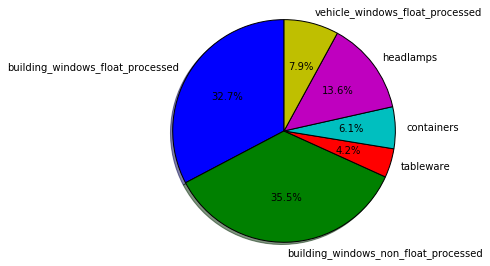

In [3]:
# La variable à prédire est le "type" 
typeV = parts.map(lambda line: line[8])
# map + reduce
distribType = typeV.map(lambda typeT: (typeT, 1)).reduceByKey(lambda a, b: a+b)
# Digramme de répartition
i = 0
name = []
data = []
while i <6:
    name = name + [distribType.collect()[i][0]]
    data = data +[int(distribType.collect()[i][1])]
    i+=1
plt.pie(data, labels=name, autopct='%1.1f%%', startangle=90, shadow=True)
plt.axis('equal')
plt.show()

Ce jeu de données ne nécessite pas de manipulation directe, il n’y a en effet aucune valeur manquante ni aucune erreur détectée. En revanche, nous constatons une inégalité dans la répartition des types : les building_windows représentent plus de 68% de la base. Nous pouvons déjà nous attendre à des difficultés d'obtenir un modèle prédictif fiable.

In [4]:
##### En trichant #####
# Utilisation de pandas pour résumer les données + afficher la matrice de corrélation
df = pd.read_csv("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF+".csv", sep = ";",header=0)
df.describe()
# Matrice de corrélation
# print(df.corr())

,Sodium,Magnesium,Aluminum,Silicon,Potassium,Calcium,Barium,Iron
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


### Mllib Statistics

In [5]:
from pyspark.mllib.stat import Statistics
# Basics Statistics
partsNum = parts.map(lambda line: line[0:8])
summary = Statistics.colStats(partsNum)
print(summary.mean())
print(summary.variance())
print(summary.numNonzeros())
Statistics.corr(partsNum, method="pearson")

[  1.34078505e+01   2.68453271e+00   1.44490654e+00   7.26509346e+01
   4.97056075e-01   8.95696262e+00   1.75046729e-01   5.70093458e-02]
[ 0.66684137  2.08054039  0.24927018  0.59992119  0.4253542   2.02536585
  0.24722699  0.0094943 ]
[ 214.  172.  214.  214.  184.  214.   38.   70.]


array([[ 1.        , -0.27373196,  0.15679367, -0.06980881, -0.2660865 ,
        -0.27544249,  0.32660288, -0.24134641],
       [-0.27373196,  1.        , -0.48179851, -0.16592672,  0.00539567,
        -0.44375003, -0.49226212,  0.08305953],
       [ 0.15679367, -0.48179851,  1.        , -0.00552372,  0.32595845,
        -0.25959201,  0.4794039 , -0.07440215],
       [-0.06980881, -0.16592672, -0.00552372,  1.        , -0.19333085,
        -0.20873215, -0.10215131, -0.09420073],
       [-0.2660865 ,  0.00539567,  0.32595845, -0.19333085,  1.        ,
        -0.31783615, -0.04261806, -0.00771905],
       [-0.27544249, -0.44375003, -0.25959201, -0.20873215, -0.31783615,
         1.        , -0.11284097,  0.12496822],
       [ 0.32660288, -0.49226212,  0.4794039 , -0.10215131, -0.04261806,
        -0.11284097,  1.        , -0.05869176],
       [-0.24134641,  0.08305953, -0.07440215, -0.09420073, -0.00771905,
         0.12496822, -0.05869176,  1.        ]])

# Classification supervisée

## Naive Bayes

In [6]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
import utils_mesure
nomF_svm = "glass_svm"
data = sc.textFile("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF_svm+".csv")

# suppression du header
nomColInit = data.first()
data2 = data.filter(lambda line: nomColInit != line) 
data = data2.map(utils_mesure.parseLine)

# Echantillonnage 60% entrainement et 40% test
training, test = data.randomSplit([0.6, 0.4], seed=0)
# construction d'un modèle Bayesien sur l'échantillon d'entrainement
model = NaiveBayes.train(training, 1.0)

# Application sur l'echantillon test
predictionAndLabel = test.map(lambda p: (model.predict(p.features), p.label))

# Calcul des indicateurs du modèle
accuracy = 1.0 * predictionAndLabel.filter(lambda (x, v): x == v ).count() / test.count()

utils_mesure.tabSum(predictionAndLabel, 7, 'Naive Bayes')



,1-Methode,2-Precision,3-Rappel,4-F_mesure
0,Naive Bayes,0.328122,0.33751,1.012529


## Decision Tree

In [8]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
import utils_mesure
data = sc.textFile("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF_svm+".csv")

# suppression du header
nomColInit = data.first()
data2 = data.filter(lambda line: nomColInit != line) 
data = data2.map(utils_mesure.parseLine)

# Echantillonnage 60% entrainement et 40% test
training, test = data.randomSplit([0.6, 0.4], seed=0)
# Construction du modèle
model = DecisionTree.trainClassifier(training, numClasses=7, categoricalFeaturesInfo={},
                                     impurity='entropy', maxDepth=10, maxBins=32)
# Test 
predictions = model.predict(test.map(lambda x: x.features))
labelsAndPredictions = test.map(lambda lp: lp.label).zip(predictions)
testErr = labelsAndPredictions.filter(lambda (v, p): v != p).count() / float(test.count())
print('Test Error = ' + str(testErr))
print('Learned classification tree model:')
print(model.toDebugString())

Test Error = 0.388888888889
Learned classification tree model:
DecisionTreeModel classifier of depth 8 with 69 nodes
  If (feature 1 <= 2.24)
   If (feature 6 <= 0.27)
    If (feature 0 <= 13.99)
     If (feature 2 <= 1.38)
      If (feature 3 <= 73.21)
       Predict: 2.0
      Else (feature 3 > 73.21)
       Predict: 6.0
     Else (feature 2 > 1.38)
      If (feature 0 <= 13.38)
       If (feature 5 <= 12.5)
        Predict: 4.0
       Else (feature 5 > 12.5)
        Predict: 2.0
      Else (feature 0 > 13.38)
       Predict: 2.0
    Else (feature 0 > 13.99)
     If (feature 4 <= 0.0)
      Predict: 5.0
     Else (feature 4 > 0.0)
      If (feature 0 <= 14.56)
       Predict: 2.0
      Else (feature 0 > 14.56)
       Predict: 6.0
   Else (feature 6 > 0.27)
    Predict: 6.0
  Else (feature 1 > 2.24)
   If (feature 2 <= 1.38)
    If (feature 3 <= 72.73)
     If (feature 3 <= 72.55)
      If (feature 0 <= 13.99)
       If (feature 5 <= 8.42)
        Predict: 2.0
       Else (feature 5 >

In [8]:
# Mesures globales du mmodèle
utils_mesure.tabSum(labelsAndPredictions, 7, 'Decision Tree')

,1-Methode,2-Precision,3-Rappel,4-F_mesure
0,Decision Tree,0.494245,0.533447,1.60034


L'affichage de l'arbre de décision n'est pas très lisible, il serait intéressant d'écrire un module qui permette de faire de la visu. Avec un taux d'erreur à 38,88% le modèle n'est pas très fiable.

## Méthodes non utilisables

### Gradient Boosted Tree

Note: GBTs do not yet support multiclass classification. For multiclass problems, please use decision trees or Random Forests.

Cette méthode n'est donc pas appliquable à notre jeu de données.

### Survival regression

L'analyse de survie repose souvent sur des séries temporelles de données longitudinales.

Notre Data Set ne correspond pas à ce type de modèle

# Classification non Supervisée

## Kmeans

In [10]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt
import numpy


data = sc.textFile("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF_svm+".csv")

# suppression du header
nomColInit = data.first()
data2 = data.filter(lambda line: nomColInit != line) 
data = data2.map(utils_mesure.parseLine2)
dataTrain = data2.map(utils_mesure.parseLine3)
# Construction du Kmeans
clusters = KMeans.train(dataTrain, 6, maxIterations=10,
        runs=10, initializationMode="random")
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = dataTrain.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 218.759357261


In [11]:
# Répartition des groupes
gpKmeans = data.map(lambda p: (clusters.predict(p[0:8]),p[8]))
gpKmeansK = gpKmeans.map(lambda p: (str(p[0])+"_"+str(p[1]),1))
gpKmeansK2 = gpKmeansK.reduceByKey(lambda a, b: a+b)
listeR = gpKmeansK2.collect()
# Construction du tableau CD
# Découpage
listeF = []
i = 0
maxN = len(listeR)
while i < maxN:
    listeR2 = listeR[i][0].split("_") + [str(listeR[i][1])]
    listeF = listeF + [listeR2]
    i += 1
listeF
# construction de la liste
i = 0
l = numpy.array([[0]*6]*6)
while i < maxN:
    a = int(listeF[i][0])
    b = int(float(listeF[i][1])) -1
    l[a][b] = int(listeF[i][2])
    i += 1
# Affichage 
df = pd.DataFrame(l, index = ['gp1_P', 'gp2_P', 'gp3_P', 'gp4_P', 'gp5_P', 'gp6_P'],
                  columns = ['gp1_R', 'gp2_R', 'gp3_R', 'gp4_R', 'gp5_R', 'gp6_R'])
df

,gp1_R,gp2_R,gp3_R,gp4_R,gp5_R,gp6_R
gp1_P,48,59,11,0,0,1
gp2_P,22,5,6,2,4,1
gp3_P,0,0,0,1,3,24
gp4_P,0,10,0,7,2,0
gp5_P,0,0,0,2,0,0
gp6_P,0,2,0,1,0,3


### Interprétation (à finir)

## Gaussian Mixture 

In [12]:
from pyspark.mllib.clustering import GaussianMixture

# Construction du model avc le mm dataTrain que Kmeans
gmm = GaussianMixture.train(dataTrain, 6)

# sortie des parameters du modele
for i in range(2):
    print ("weight = ", gmm.weights[i], "mu = ", gmm.gaussians[i].mu,
        "sigma = ", gmm.gaussians[i].sigma.toArray())

('weight = ', 0.046728397296341102, 'mu = ', DenseVector([12.907, 0.706, 1.118, 72.839, 0.285, 11.38, 0.483, 0.062]), 'sigma = ', array([[ 4.90294466, -0.05631484, -0.7275468 ,  1.22210563, -0.30635365,
        -4.72260616, -0.20142127, -0.11049502],
       [-0.05631484,  1.36791164,  0.19238203, -0.32013141,  0.15534041,
        -1.46908149, -0.03355765, -0.04377179],
       [-0.7275468 ,  0.19238203,  0.33155659, -0.71288007,  0.16348969,
         0.37368229,  0.3415917 ,  0.05340415],
       [ 1.22210563, -0.32013141, -0.71288007,  2.55753569, -0.26516784,
        -1.1155733 , -1.35886187, -0.10687848],
       [-0.30635365,  0.15534041,  0.16348969, -0.26516784,  0.09376459,
         0.02761908,  0.09712724,  0.02610997],
       [-4.72260616, -1.46908149,  0.37368229, -1.1155733 ,  0.02761908,
         6.92565306,  0.1394479 ,  0.11700052],
       [-0.20142127, -0.03355765,  0.3415917 , -1.35886187,  0.09712724,
         0.1394479 ,  1.04121094,  0.05825479],
       [-0.11049502, -0

### Interprétation (à finir)

# Mesures d'évaluation (en cours)

In [30]:
from pyspark.mllib.evaluation import MultilabelMetrics

# Instantiate metrics object
metrics = MultilabelMetrics(labelsAndPredictions)

# Summary stats
print("Recall = %s" % metrics.recall())
print("Precision = %s" % metrics.precision())
print("F1 measure = %s" % metrics.f1Measure())
print("Accuracy = %s" % metrics.accuracy)

Exception: ("You must build Spark with Hive. Export 'SPARK_HIVE=true' and run build/sbt assembly", Py4JJavaError(u'An error occurred while calling None.org.apache.spark.sql.hive.HiveContext.\n', JavaObject id=o930))

("You must build Spark with Hive. Export 'SPARK_HIVE=true' and run build/sbt assembly", ...)

# En cours


In [1]:
# PIC
from __future__ import print_function
from pyspark.mllib.clustering import PowerIterationClustering, PowerIterationClusteringModel

# Load and parse the data
data = sc.textFile("data/mllib/pic_data.txt")
similarities = data.map(lambda line: tuple([float(x) for x in line.split(' ')]))

# Cluster the data into two classes using PowerIterationClustering
model = PowerIterationClustering.train(similarities, 2, 10)

model.assignments().foreach(lambda x: print(str(x.id) + " -> " + str(x.cluster)))



In [2]:
def printM(x):
    return (str(x.id) + " -> " + str(x.cluster))
    

In [3]:
model.assignments().foreach(lambda x: printM(x))

In [12]:
# Multilayer perceptron classifier
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load training data
data = sqlContext.read.format("libsvm")\
    .load("data/mllib/sample_multiclass_classification_data.txt")
# Split the data into train and test
splits = data.randomSplit([0.6, 0.4], 1234)
train = splits[0]
test = splits[1]
# specify layers for the neural network:
# input layer of size 4 (features), two intermediate of size 5 and 4
# and output of size 3 (classes)
layers = [4, 5, 4, 3]
# create the trainer and set its parameters
trainer = MultilayerPerceptronClassifier(maxIter=100, layers=layers, blockSize=128, seed=1234)
# train the model
model = trainer.fit(train)
# compute precision on the test set
result = model.transform(test)
predictionAndLabels = result.select("prediction", "label")
evaluator = MulticlassClassificationEvaluator(metricName="precision")
print("Precision:" + str(evaluator.evaluate(predictionAndLabels)))

ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=PySparkShell, master=local[*]) created by <module> at C:\Users\lata\Anaconda2\lib\site-packages\IPython\utils\py3compat.py:278 

In [ ]:
from pyspark.ml.classification import LogisticRegression

# Load training data
training = sqlContext.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Fit the model
lrModel = lr.fit(training)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = sqlContext.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a GBT model.
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=10)

# Chain indexers and GBT in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

In [13]:
# Random Forest
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = sqlContext.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="precision")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only

Exception: ("You must build Spark with Hive. Export 'SPARK_HIVE=true' and run build/sbt assembly", Py4JJavaError(u'An error occurred while calling None.org.apache.spark.sql.hive.HiveContext.\n', JavaObject id=o733))

In [ ]:
# Classification et regression 
# Méthodes linéaires
from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint
nomF = "glass_svm"
# Load and parse the data
def parsePoint(line):
    values = [x for x in line.split(';')]
    return LabeledPoint(values[8], values[0:7])

data = sc.textFile("file:/C:/spark-1.6.0-bin-hadoop2.4/"+nomF+".csv")
data.first()
nomColInit = data.first()
#sruppression du header
data2 = data.filter(lambda line: nomColInit != line) 

parsedData = data2.map(parsePoint)

# Build the model
#model = SVMWithSGD.train(parsedData, iterations=100)

# Evaluating the model on training data
#labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
#trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedData.count())
#print("Training Error = " + str(trainErr))

# Save and load model
#model.save(sc, "myModelPath")
#sameModel = SVMModel.load(sc, "myModelPath")

In [ ]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint

# Load and parse the data
def parsePoint(line):
    values = [float(x) for x in line.split(' ')]
    return LabeledPoint(values[0], values[1:])

data = sc.textFile("data/mllib/sample_svm_data.txt")
parsedData = data.map(parsePoint)

# Build the model
model = LogisticRegressionWithLBFGS.train(parsedData)

# Evaluating the model on training data
labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedData.count())
print("Training Error = " + str(trainErr))

# Save and load model
model.save(sc, "myModelPath2")
sameModel = LogisticRegressionModel.load(sc, "myModelPath2")